In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import g20_functions as g20

data = g20.scaleData(g20.loadHeart())['Z-Score']

data.pop('DEATH_EVENT')

variables = data.columns.values

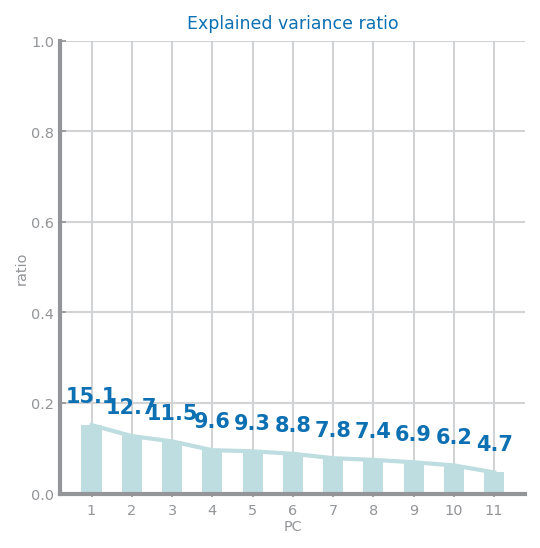

In [13]:
from sklearn.decomposition import PCA

cov_mtx = data.cov()
eigvals, eigvecs = np.linalg.eig(cov_mtx)

pca = PCA()
pca.fit(data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(4, 4))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
plt.show()

In [14]:
transf = pca.transform(data)
transf.shape

(299, 11)

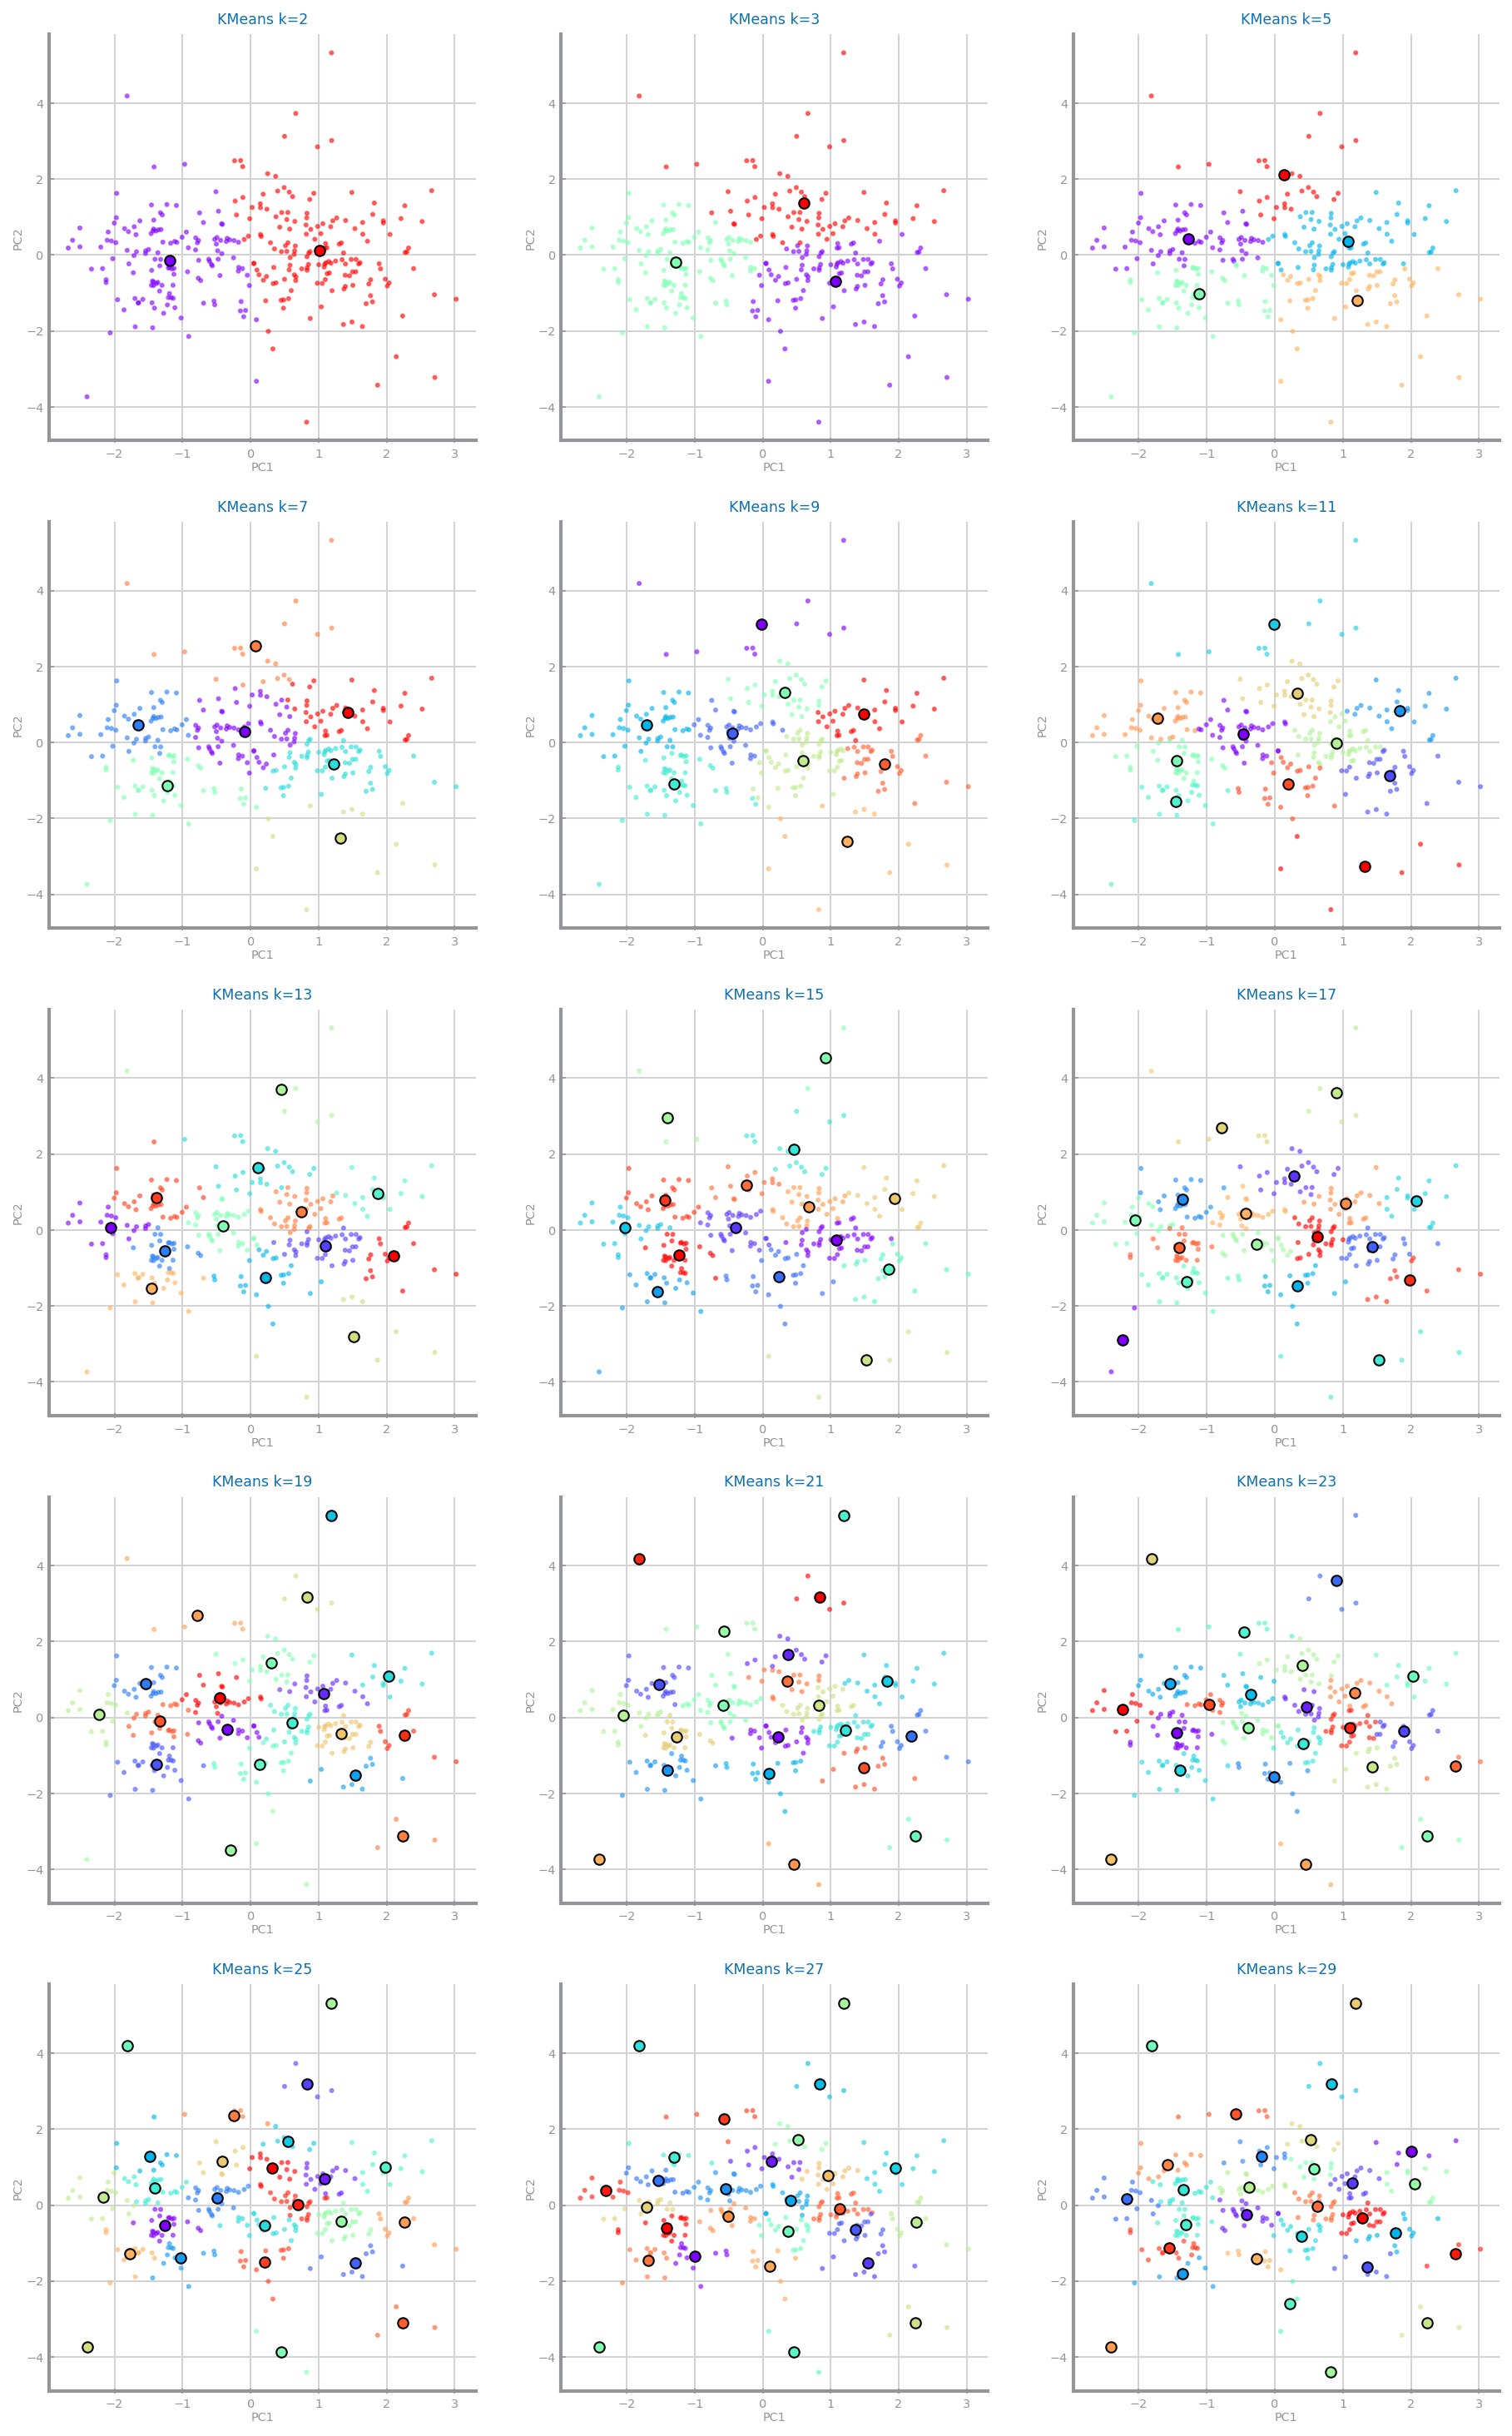

In [15]:
data = pd.DataFrame(transf[:,:2], columns=['PC1', 'PC2'])
eixo_x = 0
eixo_y = 1

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, eixo_x, eixo_y, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

In [16]:
pca.explained_variance_ratio_

array([0.15117862, 0.12685579, 0.11515677, 0.09575076, 0.093254  ,
       0.08772777, 0.07802384, 0.07431211, 0.06901927, 0.06208497,
       0.0466361 ])

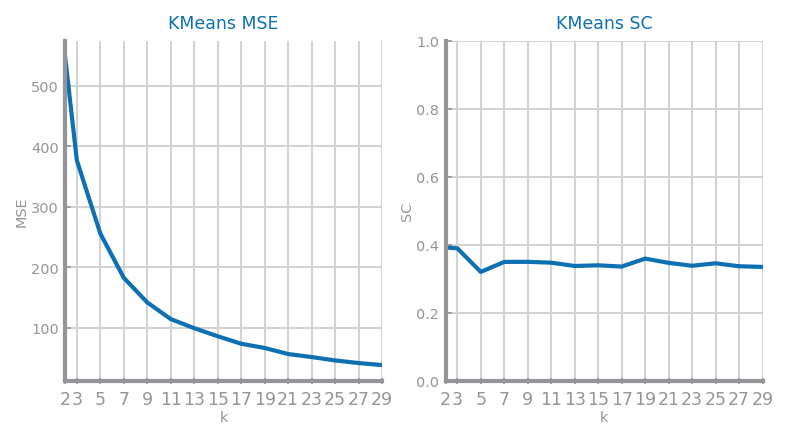

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

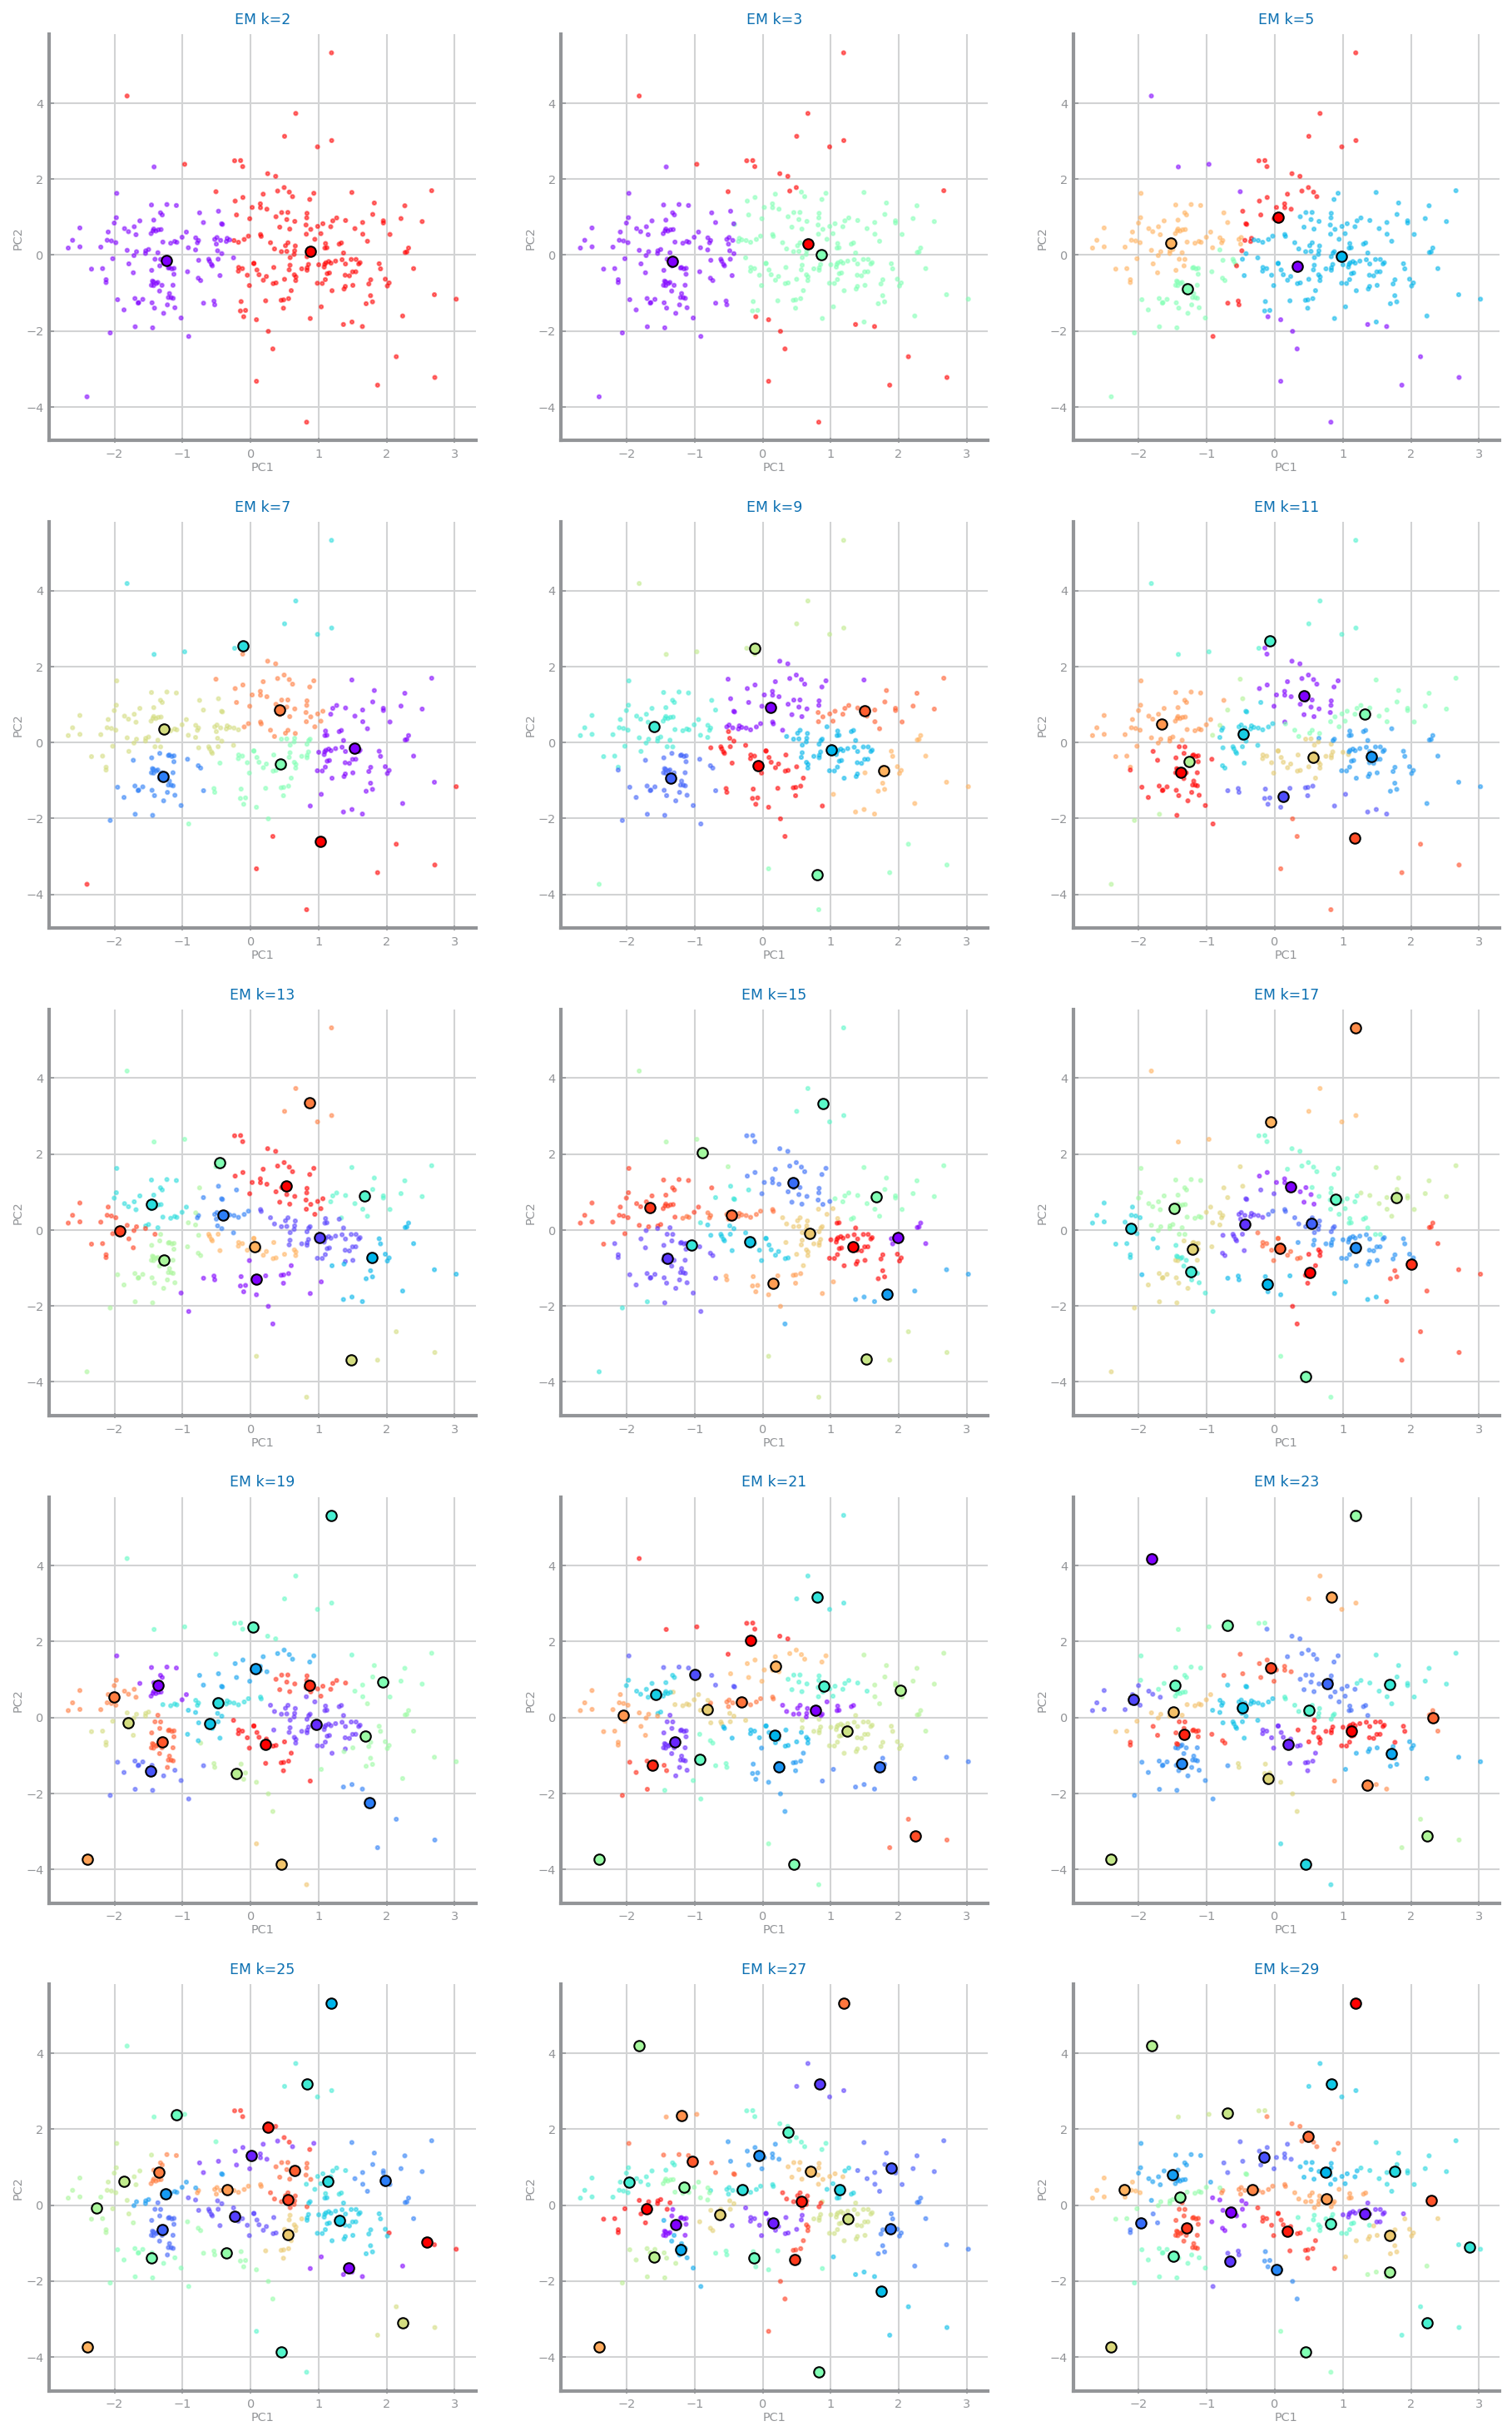

In [18]:
from sklearn.mixture import GaussianMixture

mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = GaussianMixture(n_components=k)
    estimator.fit(data)
    labels = estimator.predict(data)
    mse.append(ds.compute_mse(data.values, labels, estimator.means_))
    sc.append(silhouette_score(data, labels))
    ds.plot_clusters(data, eixo_x, eixo_y, labels.astype(float), estimator.means_, k,
                     f'EM k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

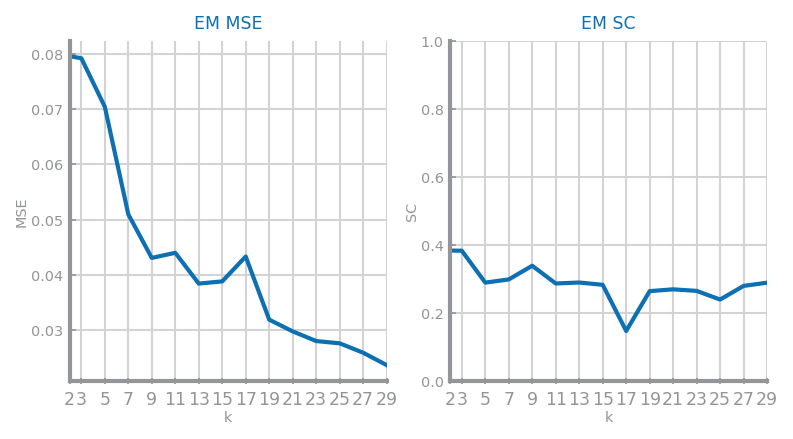

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='EM MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='EM SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

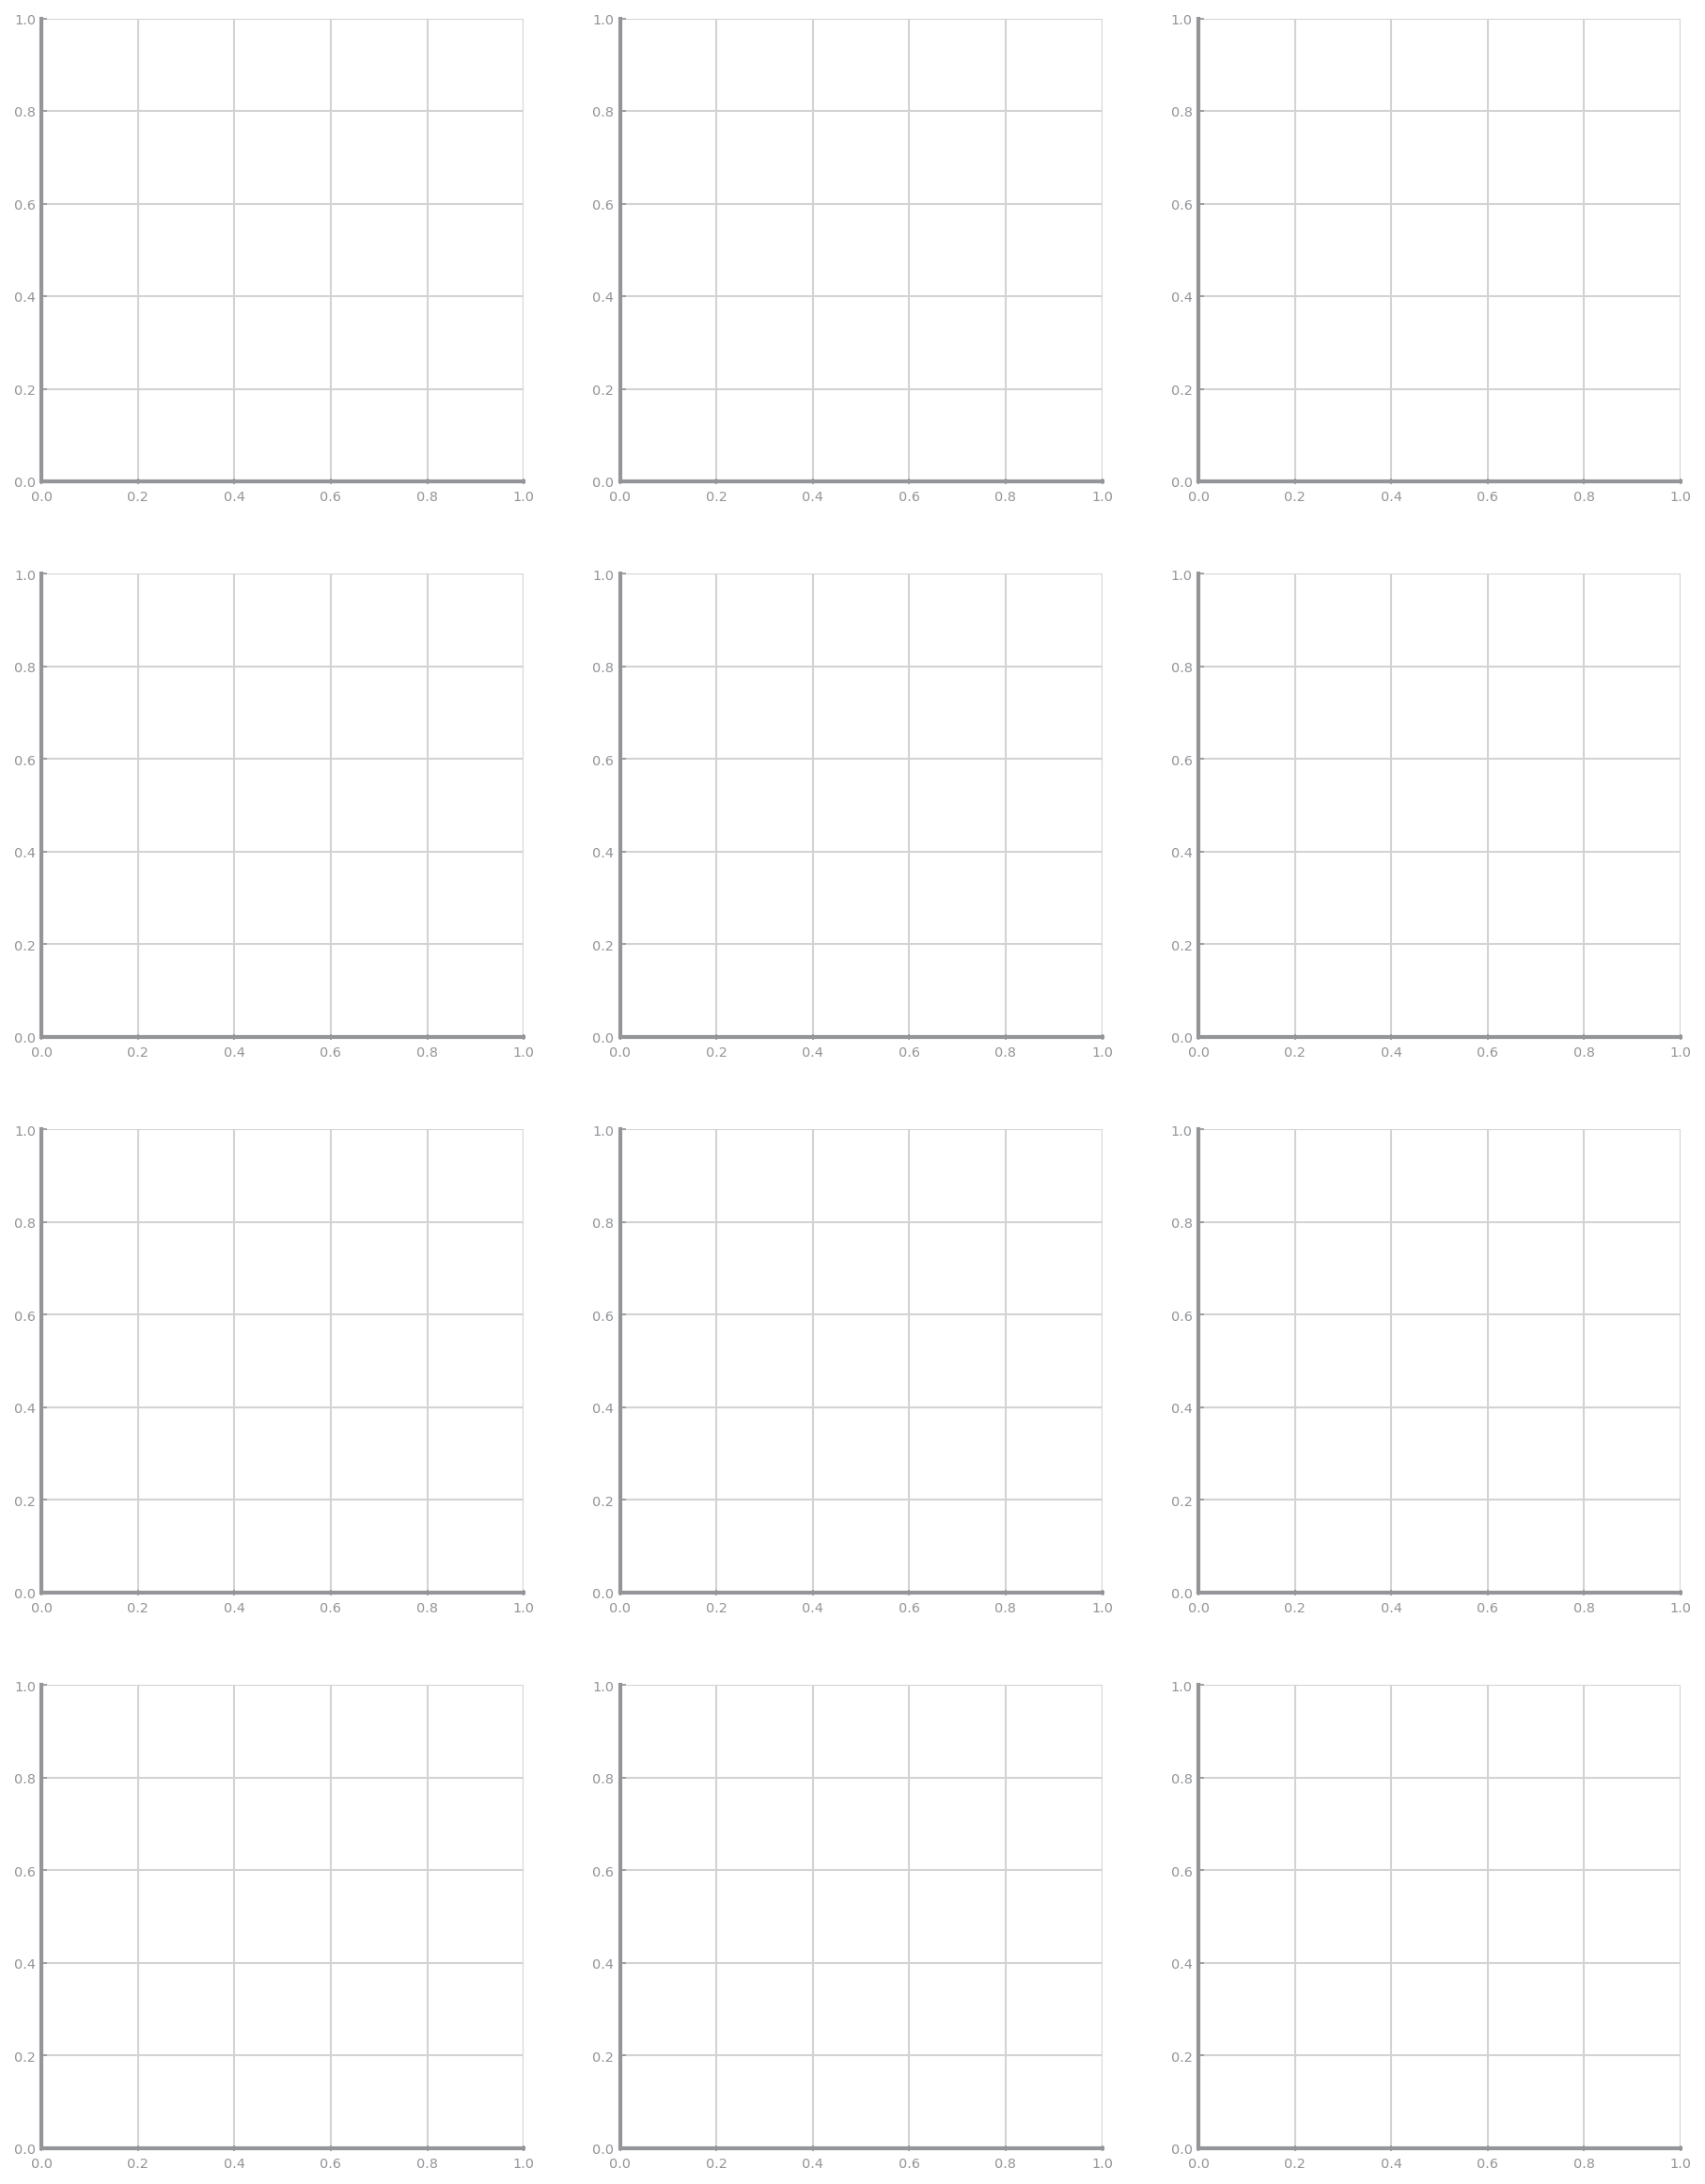

In [21]:
from sklearn.cluster import DBSCAN

EPS = [2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(EPS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
plt.show()


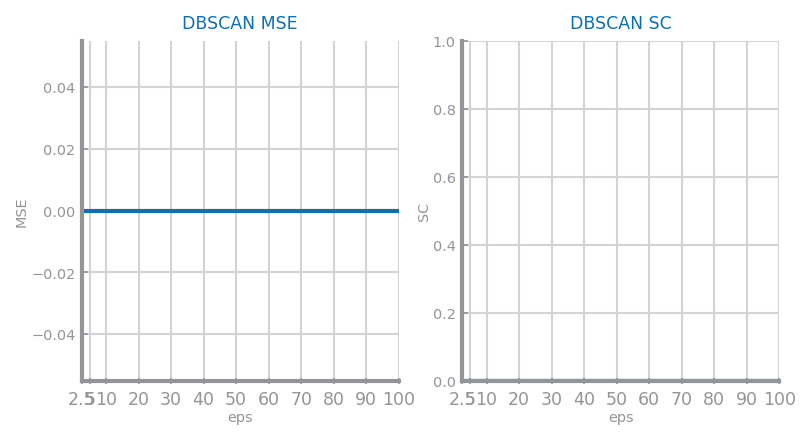

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(EPS, mse, title='DBSCAN MSE', xlabel='eps', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(EPS, sc, title='DBSCAN SC', xlabel='eps', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

In [23]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
distances = []
for m in METRICS:
    dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
    distances.append(dist)

print('AVG distances among records', distances)
distances[0] = 80
distances[1] = 50
distances[2] = 80
distances[3] = 0.0005
distances[4] = 0.0009
print('CHOSEN EPS', distances)

AVG distances among records [2.1711119001937296, 2.751570716505793, 1.9648131389610783, 0.9999857291192087, 0.9966555183946488]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]


1
1
1
1


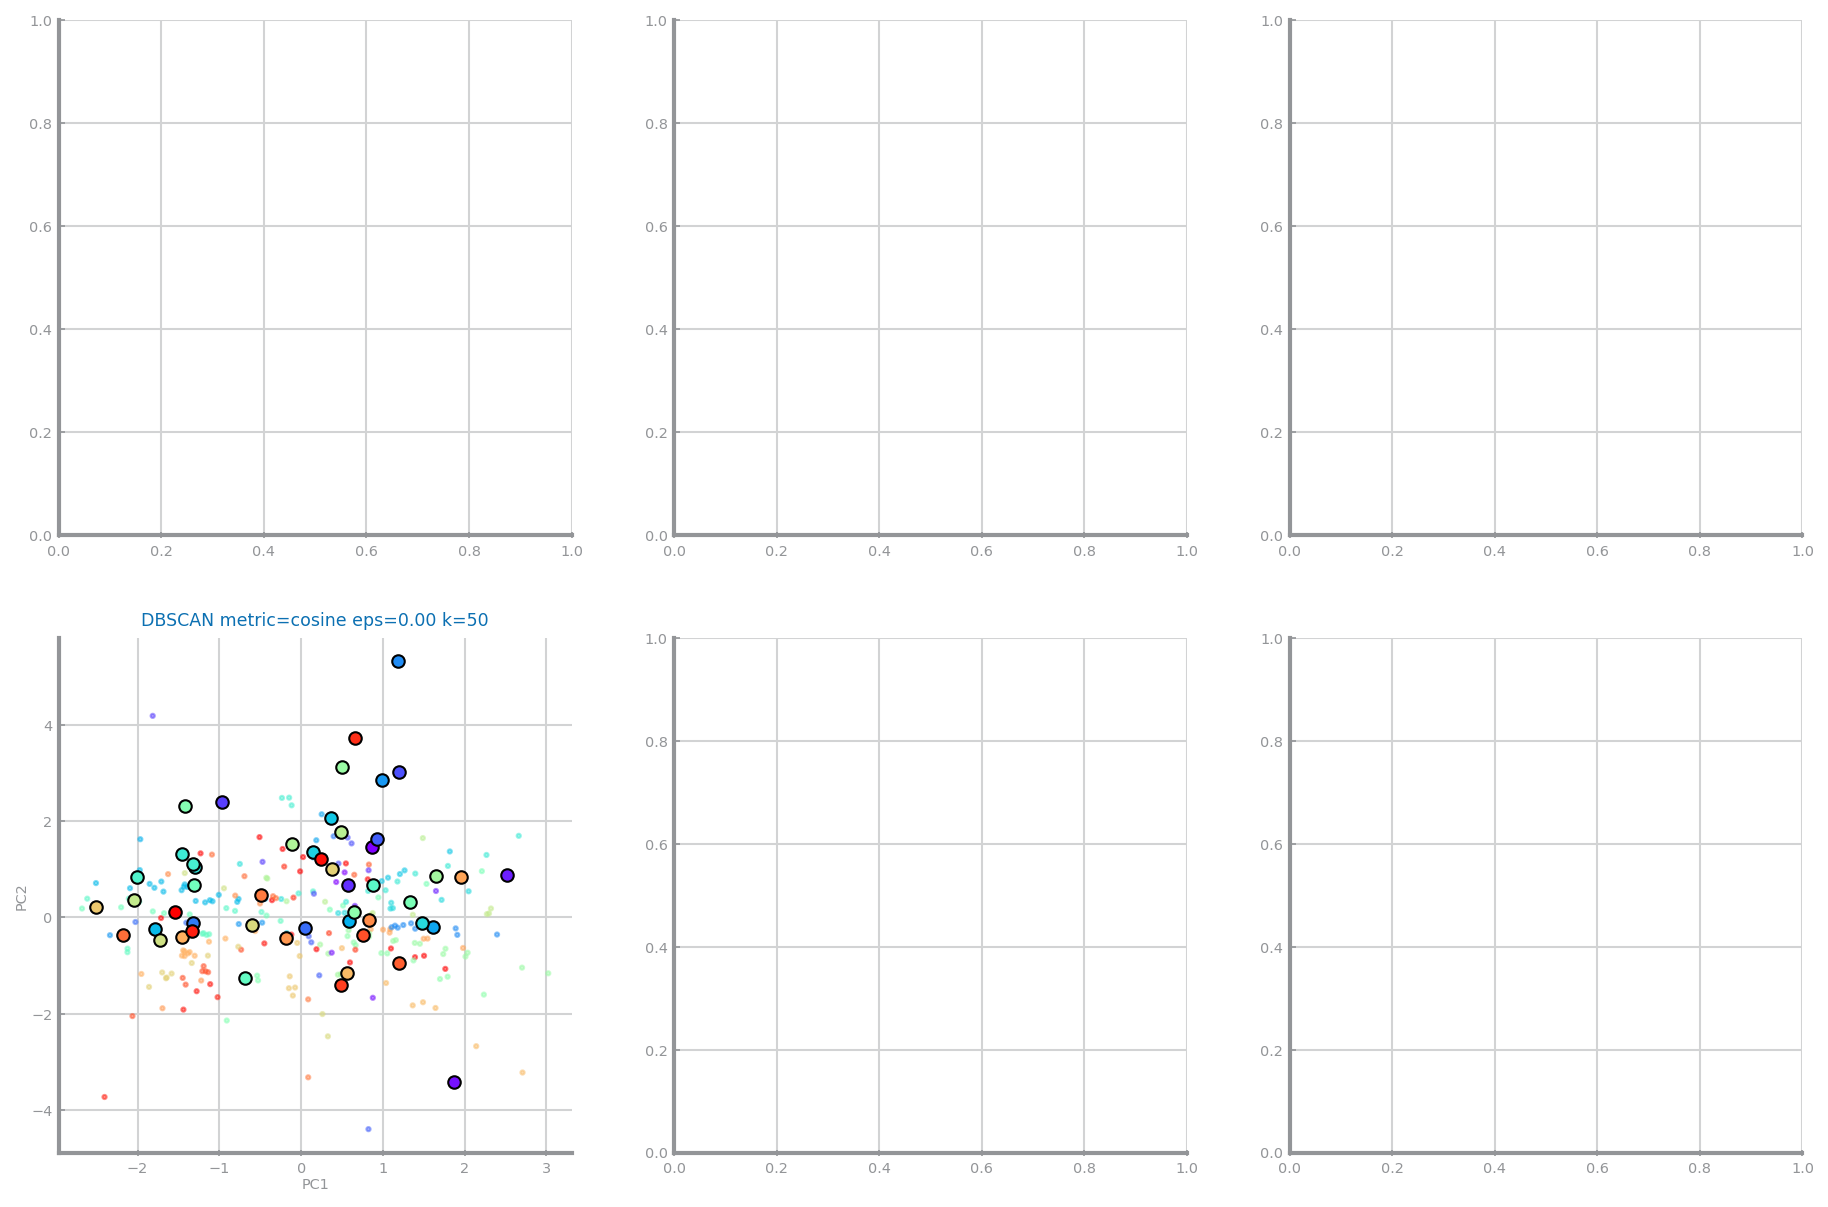

In [24]:
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        print(k)
        mse.append(0)
        sc.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

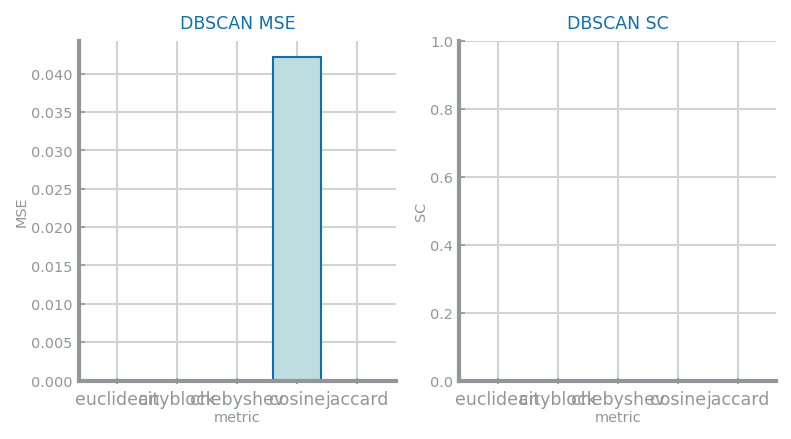

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

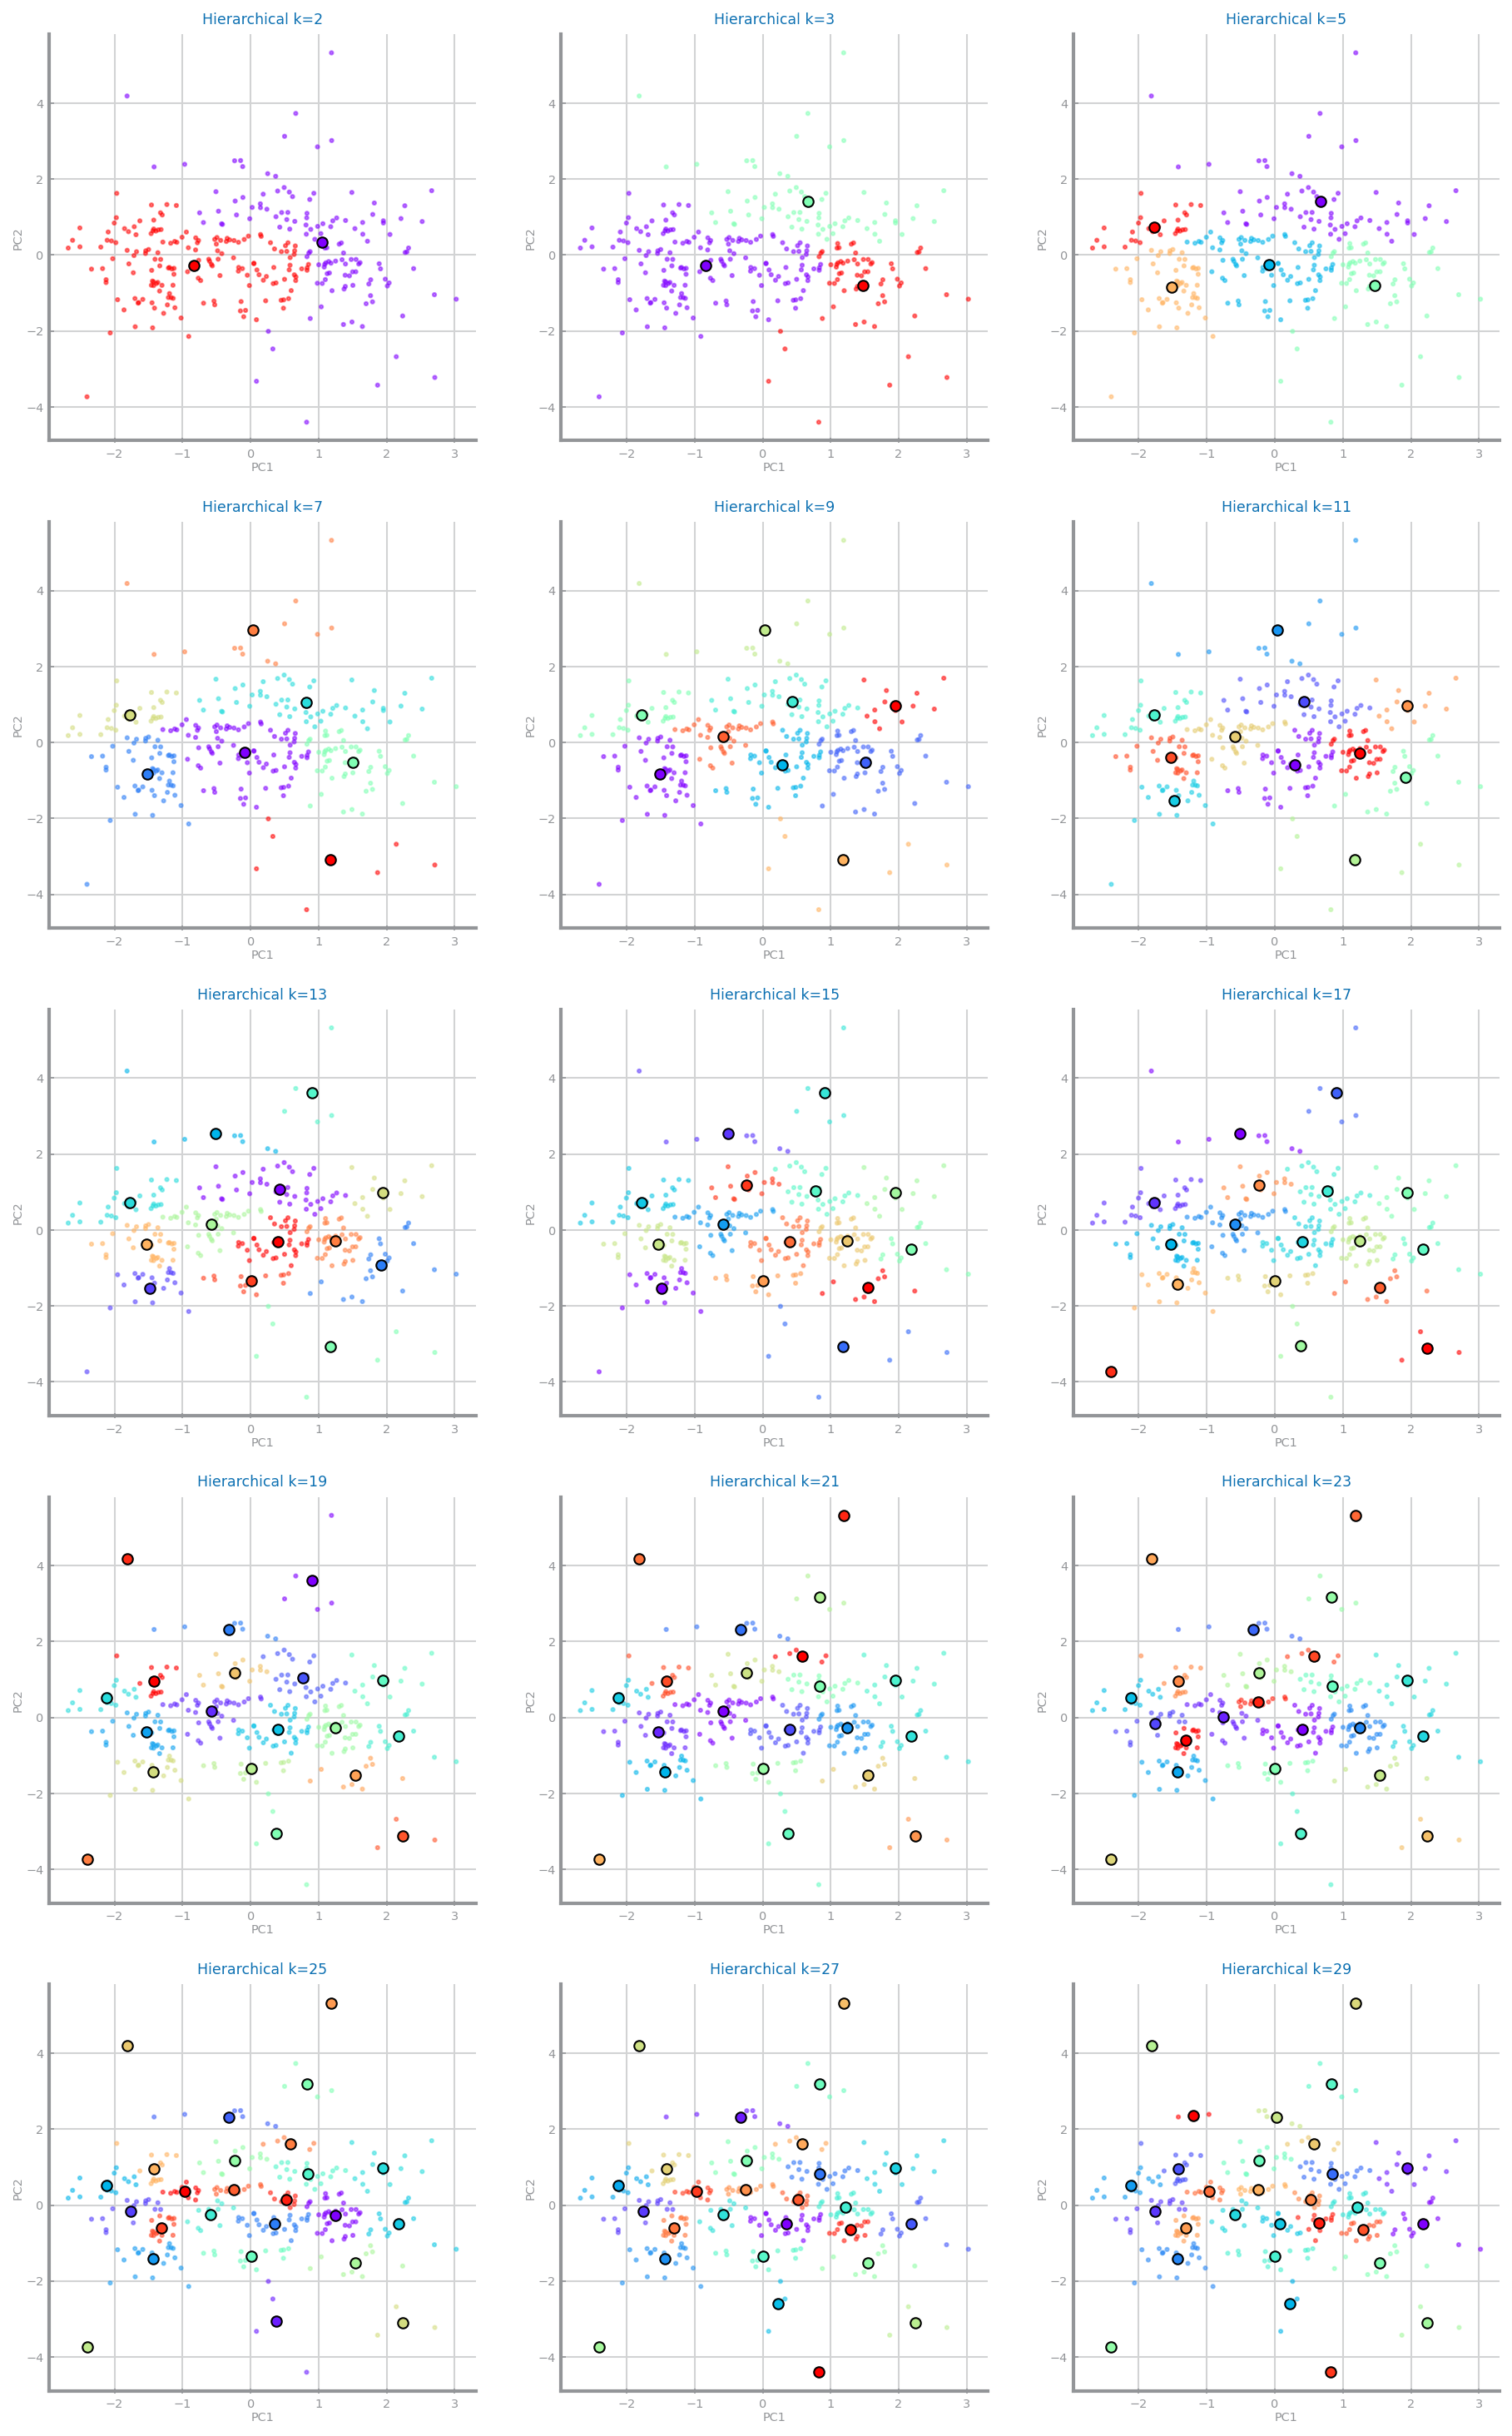

In [26]:
from sklearn.cluster import AgglomerativeClustering

mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(N_CLUSTERS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = AgglomerativeClustering(n_clusters=k)
    estimator.fit(data)
    labels = estimator.labels_
    centers = ds.compute_centroids(data, labels)
    mse.append(ds.compute_mse(data.values, labels, centers))
    sc.append(silhouette_score(data, labels))
    ds.plot_clusters(data, eixo_x, eixo_y, labels, centers, k,
                     f'Hierarchical k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

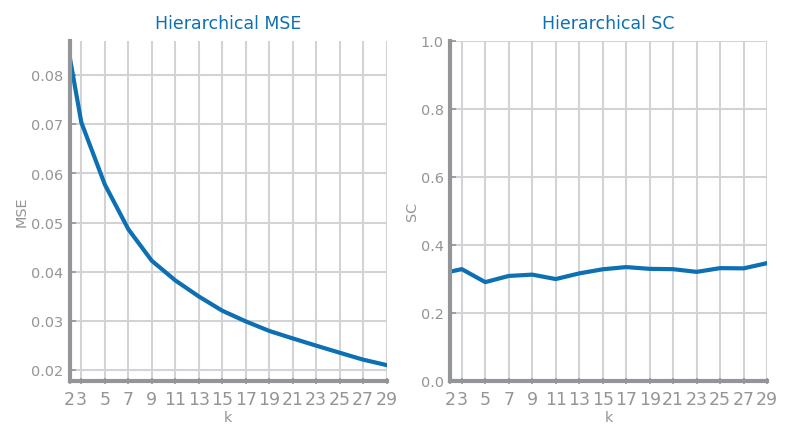

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='Hierarchical MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='Hierarchical SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

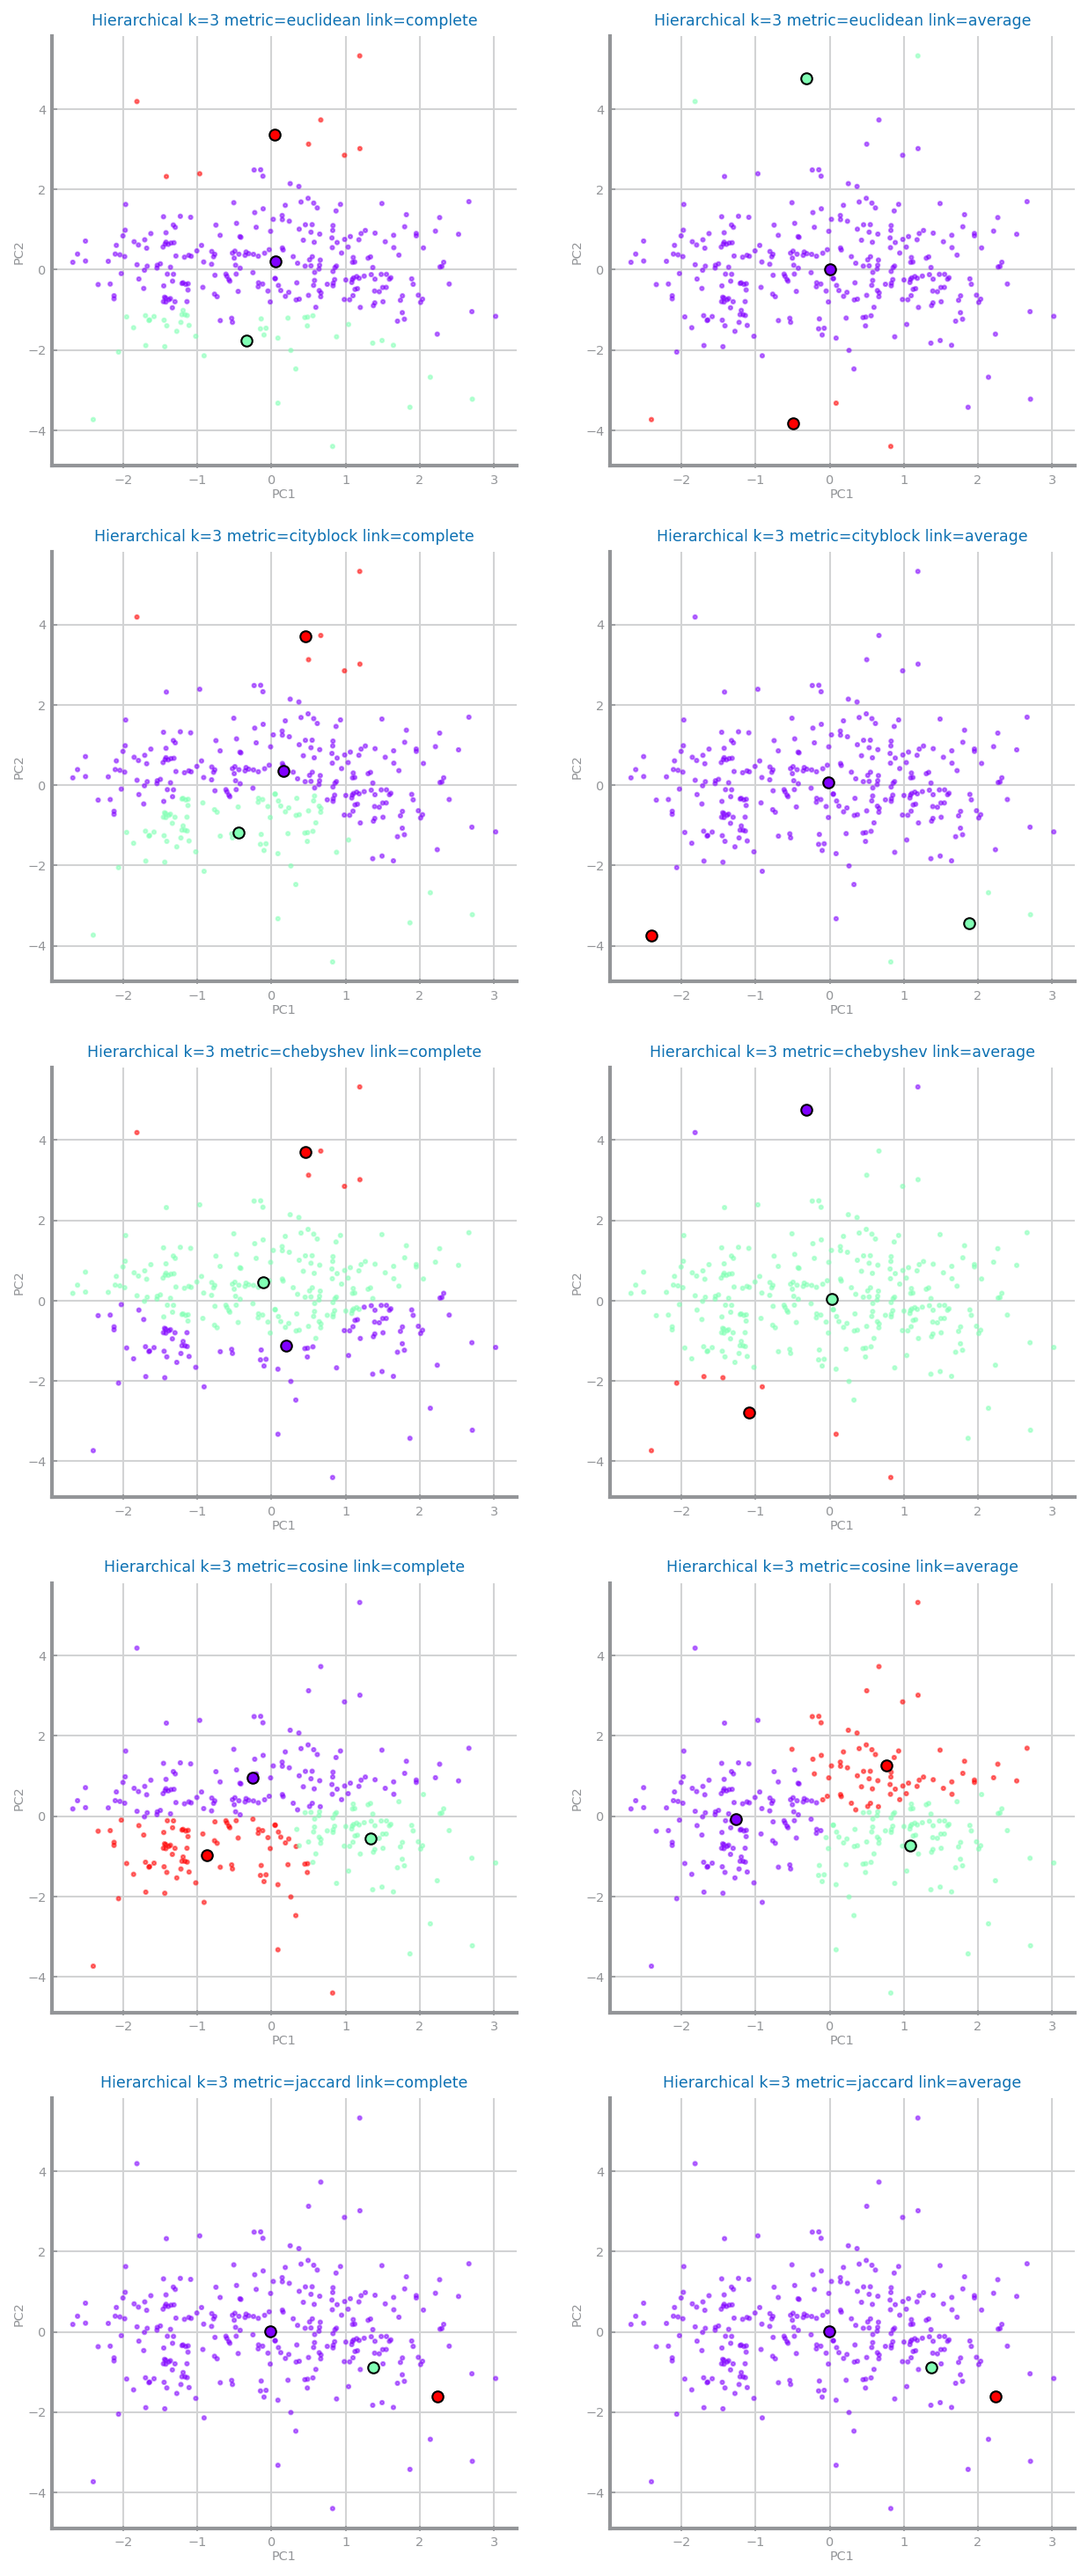

In [28]:
METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
LINKS = ['complete', 'average']
k = 3
values_mse = {}
values_sc = {}
rows = len(METRICS)
cols = len(LINKS)
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
for i in range(len(METRICS)):
    mse: list = []
    sc: list = []
    m = METRICS[i]
    for j in range(len(LINKS)):
        link = LINKS[j]
        estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
        estimator.fit(data)
        labels = estimator.labels_
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, eixo_x, eixo_y, labels, centers, k,
                         f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
    values_mse[m] = mse
    values_sc[m] = sc
plt.show()

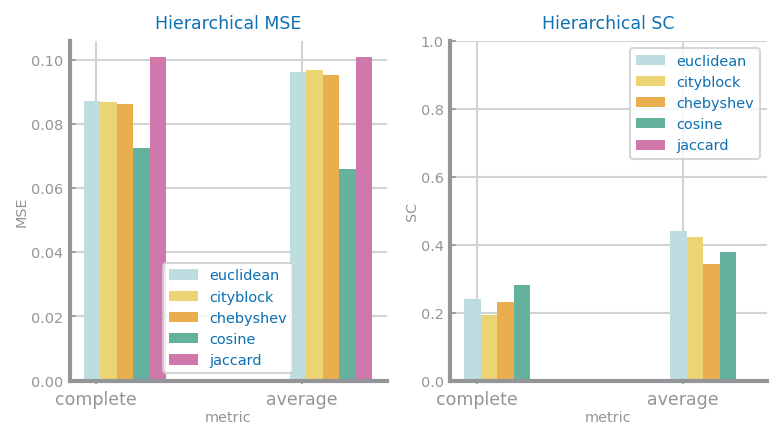

In [29]:
_, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
ds.multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()